# 🧠 Part 1: Motor Imagery (MI) Classification

___

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils.class_weight import compute_class_weight
from scipy.signal import butter, filtfilt
from scipy.signal import welch
import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pywt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight
import joblib 

## Loading & Display MI Data

In [2]:
def load_eeg_data(subject_range, session_range, base_path, dataset_type):
    all_data = []
    
    for subject_id in subject_range:
        sessions = session_range if session_range else [1]
        for session_id in sessions:
            path = f'{base_path}/S{subject_id}/{session_id}/EEGdata.csv'
            try:
                df = pd.read_csv(path)
                df['Subject'] = f'S{subject_id}'
                if dataset_type == 'train':
                    df['Session'] = session_id
                all_data.append(df)
            except FileNotFoundError:
                print(f"Missing file: {path}")
                
    return pd.concat(all_data, ignore_index=True)

In [3]:
df_train_labels = pd.read_csv("/kaggle/input/mtcaic3/train.csv")
df_train_labels_MI = df_train_labels[df_train_labels["task"]=="MI"]
df_train_labels_SSVEP = df_train_labels[df_train_labels["task"]=="SSVEP"]

In [4]:
df_valid_labels = pd.read_csv("/kaggle/input/mtcaic3/validation.csv")
df_valid_labels_MI = df_valid_labels[df_valid_labels["task"]=="MI"]
df_valid_labels_SSVEP = df_valid_labels[df_valid_labels["task"]=="SSVEP"]

In [5]:
df_test_labels = pd.read_csv("/kaggle/input/mtcaic3/test.csv")
df_test_labels_MI = df_test_labels[df_test_labels["task"]=="MI"]
df_test_labels_SSVEP = df_test_labels[df_test_labels["task"]=="SSVEP"]

In [6]:
base_path_train = '/kaggle/input/mtcaic3/MI/train'
base_path_valid = '/kaggle/input/mtcaic3/MI/validation'
base_path_test  = '/kaggle/input/mtcaic3/MI/test'

df_train = load_eeg_data(subject_range=range(1, 31), session_range=range(1, 9), base_path=base_path_train, dataset_type='train')
df_valid = load_eeg_data(subject_range=range(31, 36), session_range=None, base_path=base_path_valid, dataset_type='valid')
df_test  = load_eeg_data(subject_range=range(36, 41), session_range=None, base_path=base_path_test, dataset_type='test')

In [7]:
df_test.head()

,Time,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Battery,Counter,Validation,Subject
0,1.009153e+06,330239.34375,323632.81250,345898.28125,338054.68750,345418.15625,311182.53125,297394.71875,297307.09375,-0.059082,0.867188,-0.568604,-2.380371,1.220703,0.427246,46.666672,192054.0,1.0,S36
1,1.009153e+06,323064.96875,323937.31250,340198.40625,335607.71875,343657.71875,311745.06250,297800.18750,297691.18750,-0.058350,0.866943,-0.566162,-2.990722,1.434326,0.793457,46.666672,192055.0,1.0,S36
2,1.009153e+06,331645.28125,328326.50000,351425.59375,342840.37500,348208.62500,313061.12500,299272.25000,298978.37500,-0.061279,0.867432,-0.562012,-3.448486,1.739502,1.312256,46.666672,192056.0,1.0,S36
3,1.009153e+06,344305.31250,330826.65625,364183.15625,349801.59375,352790.03125,313330.62500,299791.62500,299405.93750,-0.061035,0.868896,-0.560059,-4.211425,2.014160,1.770019,46.666672,192057.0,1.0,S36
4,1.009153e+06,343637.15625,327964.31250,360931.15625,346940.93750,351091.65625,312175.12500,298643.56250,298387.40625,-0.058594,0.869141,-0.554443,-4.913330,2.197265,2.197265,46.666672,192058.0,1.0,S36


In [8]:
df_train.head()

,Time,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Battery,Counter,Validation,Subject,Session
0,471108.629297,259145.062500,255463.203125,280156.78125,297592.40625,268555.25000,255108.156250,232334.953125,239896.906250,-0.156006,0.782959,-0.566162,-10.437011,6.835937,13.610839,93.333344,405287.0,1.0,S1,1
1,471108.634537,259071.937500,255626.625000,282968.28125,297913.18750,269795.59375,255109.765625,232506.515625,240036.203125,-0.143799,0.778809,-0.562500,-9.582519,6.866455,13.305663,93.333344,405288.0,1.0,S1,1
2,471108.634549,259450.296875,255598.296875,283131.25000,297802.50000,269435.43750,255080.796875,232323.593750,239907.625000,-0.137451,0.773926,-0.560303,-9.185790,7.019042,13.183593,93.333344,405289.0,1.0,S1,1
3,471108.636824,259770.734375,255431.093750,280456.65625,297436.09375,267998.68750,255079.453125,232064.765625,239711.656250,-0.133545,0.770508,-0.560303,-8.483886,7.385253,12.847899,93.333344,405290.0,1.0,S1,1
4,471108.639355,259562.062500,255346.515625,278669.31250,297312.09375,267488.87500,255097.703125,232085.765625,239713.000000,-0.132324,0.774902,-0.561523,-7.568359,7.873535,12.390136,93.333344,405291.0,1.0,S1,1


In [9]:
df_valid.head()

,Time,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Battery,Counter,Validation,Subject
0,1.000500e+06,311426.59375,321080.50000,359498.84375,368457.43750,317776.90625,298857.40625,288538.78125,313009.37500,0.000244,0.820801,-0.526123,14.160155,11.108397,-0.946045,66.666672,900485.0,1.0,S31
1,1.000500e+06,309546.00000,311528.53125,352108.31250,366678.78125,309605.56250,296327.18750,287078.75000,310669.50000,0.002197,0.819092,-0.526855,14.038085,11.444091,-1.129150,66.666672,900486.0,1.0,S31
2,1.000500e+06,310267.96875,312397.37500,355520.78125,368320.65625,311393.15625,298072.96875,288286.65625,311938.46875,0.005127,0.819580,-0.526855,14.068603,11.657714,-1.342773,66.666672,900487.0,1.0,S31
3,1.000500e+06,312545.87500,322326.75000,364975.56250,371095.56250,320610.21875,301668.00000,290481.21875,315051.06250,0.009277,0.818359,-0.529053,14.038085,11.901855,-1.495361,66.666672,900488.0,1.0,S31
4,1.000500e+06,313246.21875,327401.46875,367259.75000,371133.31250,324231.18750,302074.53125,290579.93750,315634.00000,0.014648,0.819336,-0.530029,13.854980,12.023925,-1.525879,66.666672,900489.0,1.0,S31


In [10]:
df_MI = pd.concat([df_train, df_valid, df_test], ignore_index=True)
df_MI.head()

,Time,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Battery,Counter,Validation,Subject,Session
0,471108.629297,259145.062500,255463.203125,280156.78125,297592.40625,268555.25000,255108.156250,232334.953125,239896.906250,-0.156006,0.782959,-0.566162,-10.437011,6.835937,13.610839,93.333344,405287.0,1.0,S1,1.0
1,471108.634537,259071.937500,255626.625000,282968.28125,297913.18750,269795.59375,255109.765625,232506.515625,240036.203125,-0.143799,0.778809,-0.562500,-9.582519,6.866455,13.305663,93.333344,405288.0,1.0,S1,1.0
2,471108.634549,259450.296875,255598.296875,283131.25000,297802.50000,269435.43750,255080.796875,232323.593750,239907.625000,-0.137451,0.773926,-0.560303,-9.185790,7.019042,13.183593,93.333344,405289.0,1.0,S1,1.0
3,471108.636824,259770.734375,255431.093750,280456.65625,297436.09375,267998.68750,255079.453125,232064.765625,239711.656250,-0.133545,0.770508,-0.560303,-8.483886,7.385253,12.847899,93.333344,405290.0,1.0,S1,1.0
4,471108.639355,259562.062500,255346.515625,278669.31250,297312.09375,267488.87500,255097.703125,232085.765625,239713.000000,-0.132324,0.774902,-0.561523,-7.568359,7.873535,12.390136,93.333344,405291.0,1.0,S1,1.0


In [11]:
df_MI = df_MI.drop(["Time","Battery","Counter"],axis=1)

## MI Data Preprocessing

In [12]:
df_MI["Session"]=df_MI["Session"].fillna(0)

In [13]:
df_MI = df_MI.copy()

columns_to_exclude = ['Validation', 'Session', 'Subject']
columns_to_standardize = [
    col for col in df_MI.columns 
    if col not in columns_to_exclude and np.issubdtype(df_MI[col].dtype, np.number)
]

val_data = df_MI[df_MI['Validation'] == 1]
mean_values = val_data[columns_to_standardize].mean()
std_values = val_data[columns_to_standardize].std()

std_values = std_values.replace(0, 1)

df_MI[columns_to_standardize] = (df_MI[columns_to_standardize] - mean_values) / std_values
df_MI.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Validation,Subject,Session
0,-1.589184,-1.700273,-0.754915,-0.370858,-0.663074,-1.191194,-1.781023,-1.627942,-1.413844,-1.870857,-1.080588,-3.588570,1.861030,5.996946,1.0,S1,1.0
1,-1.592103,-1.694357,-0.716722,-0.366981,-0.652823,-1.191137,-1.775412,-1.623134,-1.250756,-1.938197,-1.060604,-3.287373,1.870291,5.856387,1.0,S1,1.0
2,-1.577002,-1.695383,-0.714508,-0.368319,-0.655799,-1.192148,-1.781395,-1.627572,-1.165950,-2.017422,-1.048613,-3.147531,1.916594,5.800164,1.0,S1,1.0
3,-1.564214,-1.701436,-0.750841,-0.372747,-0.667675,-1.192195,-1.789861,-1.634335,-1.113762,-2.072879,-1.048613,-2.900119,2.027723,5.645549,1.0,S1,1.0
4,-1.572542,-1.704497,-0.775121,-0.374246,-0.671888,-1.191558,-1.789174,-1.634289,-1.097453,-2.001577,-1.055274,-2.577407,2.175894,5.434710,1.0,S1,1.0


In [14]:
def select_low_noise_experiments(df, noise_columns, exp_length, top_n=2):
    df_filtered = df[df['Session'] != 0].copy()
    df_filtered['Experiment'] = df_filtered.groupby(['Subject', 'Session']).cumcount() // exp_length + 1

    experiment_variances = (
        df_filtered.groupby(['Subject', 'Session', 'Experiment'])[noise_columns]
        .var()
        .mean(axis=1)
        .reset_index(name='avg_noise')
    )

    best_experiments = (
        experiment_variances
        .sort_values(['Subject', 'Session', 'avg_noise'])
        .groupby(['Subject', 'Session'])
        .head(top_n)
    )

    df_best = df_filtered.merge(best_experiments, on=['Subject', 'Session', 'Experiment'])
    return df_best

In [15]:
noise_columns = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
df_best = select_low_noise_experiments(df_MI, noise_columns, top_n=3,exp_length=2250)

print("✅ Best low-noise experiments:")
print(df_best[['Subject', 'Session', 'Experiment']].drop_duplicates().sort_values(['Subject', 'Session']).head(10))

print(f"Shape of selected data: {df_best.shape}")

✅ Best low-noise experiments:
      Subject  Session  Experiment
0          S1      1.0           3
2250       S1      1.0           5
4500       S1      1.0           9
6750       S1      2.0           3
9000       S1      2.0           4
11250      S1      2.0           8
13500      S1      3.0           4
15750      S1      3.0           6
18000      S1      3.0           7
20250      S1      4.0           2
Shape of selected data: (1620000, 19)


In [16]:
feature_columns = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8', 'AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']

In [17]:
def merge(df_data, df_labels, left_on, right_on, feature_columns, group_size=2250):
    df_data = df_data.copy()
    df_labels = df_labels.copy()

    
    if 'Subject' in df_data.columns:
        df_data['Subject'] = df_data['Subject'].astype(str).str.upper()
    if 'subject_id' in df_labels.columns:
        df_labels['subject_id'] = df_labels['subject_id'].astype(str).str.upper()

    
    for col in left_on:
        if col in df_data.columns:
            try:
                df_data[col] = df_data[col].astype(int)
            except ValueError:
                pass
    for col in right_on:
        if col in df_labels.columns:
            try:
                df_labels[col] = df_labels[col].astype(int)
            except ValueError:
                pass

    
    df_merged = df_data.merge(
        df_labels,
        left_on=left_on,
        right_on=right_on,
        how='inner'
    ).reset_index(drop=True)

    
    X = df_merged[feature_columns].values
    n_samples = X.shape[0] // group_size
    X_reshaped = X.reshape(n_samples, group_size, len(feature_columns))

    return df_merged, X_reshaped

In [18]:
left_keys = ["Subject", "Session", "Experiment"]
right_keys = ["subject_id", "trial_session", "trial"]

df_merged_train, X_train = merge(df_best, df_train_labels_MI, left_keys, right_keys, feature_columns)
print("✅ X_train shape:", X_train.shape)

✅ X_train shape: (720, 2250, 14)


In [19]:
df_merged_train.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,...,Subject,Session,Experiment,avg_noise,id,subject_id,task,trial_session,trial,label
0,-1.595075,-1.708268,-0.761245,-0.376915,-0.664531,-1.194907,-1.790132,-1.647276,-1.720450,-1.470774,...,S1,1,3,0.010478,3,S1,MI,1,3,Left
1,-1.598041,-1.699930,-0.721416,-0.372577,-0.653651,-1.194315,-1.783190,-1.641370,-1.684570,-1.466813,...,S1,1,3,0.010478,3,S1,MI,1,3,Left
2,-1.586651,-1.700228,-0.709032,-0.372646,-0.653501,-1.195409,-1.786869,-1.643999,-1.700879,-1.486619,...,S1,1,3,0.010478,3,S1,MI,1,3,Left
3,-1.576542,-1.709110,-0.741584,-0.377186,-0.664535,-1.197202,-1.796633,-1.651935,-1.681309,-1.462852,...,S1,1,3,0.010478,3,S1,MI,1,3,Left
4,-1.582426,-1.713832,-0.773049,-0.379668,-0.671057,-1.196626,-1.798236,-1.653672,-1.632382,-1.502464,...,S1,1,3,0.010478,3,S1,MI,1,3,Left


In [20]:
df_sess0 = df_MI[df_MI['Session'] == 0].copy()
mid = len(df_sess0) // 2

df_valid_p = df_sess0.iloc[:mid].copy()
df_test_p  = df_sess0.iloc[mid:].copy()

for df_part in [df_valid_p, df_test_p]:
    df_part['Experiment'] = df_part.groupby(['Subject', 'Session']).cumcount() // 2250 + 1

In [21]:
left_keys = ["Subject", "Experiment"]
right_keys = ["subject_id", "trial"]
df_merged_valid, X_val = merge(df_valid_p, df_valid_labels_MI, left_keys, right_keys, feature_columns)
print("✅ X_valid shape:", X_val.shape)

✅ X_valid shape: (50, 2250, 14)


In [22]:
df_merged_test, X_test = merge(df_test_p, df_test_labels_MI, left_keys, right_keys, feature_columns)
print("✅ X_test shape:", X_test.shape)

✅ X_test shape: (50, 2250, 14)


In [23]:
df_merged_valid.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,...,Validation,Subject,Session,Experiment,id,subject_id,task,trial_session,trial,label
0,0.497386,0.675181,0.322904,0.485657,-0.256243,0.334637,0.057321,0.895247,0.673684,-1.256868,...,1.0,S31,0.0,1,4801,S31,MI,1,1,Left
1,0.422331,0.329384,0.222508,0.464160,-0.323782,0.246391,0.009565,0.814496,0.699778,-1.284597,...,1.0,S31,0.0,1,4801,S31,MI,1,1,Left
2,0.451145,0.360837,0.268865,0.484004,-0.309007,0.307278,0.049074,0.858289,0.738919,-1.276674,...,1.0,S31,0.0,1,4801,S31,MI,1,1,Left
3,0.542057,0.720297,0.397303,0.517543,-0.232825,0.432661,0.120855,0.965708,0.794369,-1.296481,...,1.0,S31,0.0,1,4801,S31,MI,1,1,Left
4,0.570008,0.904010,0.428332,0.518000,-0.202897,0.446839,0.124084,0.985826,0.866128,-1.280636,...,1.0,S31,0.0,1,4801,S31,MI,1,1,Left


In [24]:
df_merged_test.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,...,Gyro3,Validation,Subject,Session,Experiment,id,subject_id,task,trial_session,trial
0,1.248209,0.767579,0.138148,0.118192,-0.027780,0.764496,0.346986,0.353345,-0.118924,-0.504237,...,-0.075203,1.0,S36,0.0,1,4901,S36,MI,1,1
1,0.961877,0.778602,0.060718,0.088617,-0.042331,0.784116,0.360248,0.366600,-0.109139,-0.508199,...,0.093468,1.0,S36,0.0,1,4901,S36,MI,1,1
2,1.304320,0.937498,0.213234,0.176035,-0.004716,0.830016,0.408397,0.411022,-0.148280,-0.500276,...,0.332418,1.0,S36,0.0,1,4901,S36,MI,1,1
3,1.809585,1.028008,0.386538,0.260172,0.033150,0.839415,0.425385,0.425778,-0.145018,-0.476509,...,0.543256,1.0,S36,0.0,1,4901,S36,MI,1,1
4,1.782919,0.924386,0.342362,0.225597,0.019113,0.799115,0.387833,0.390628,-0.112401,-0.472548,...,0.740039,1.0,S36,0.0,1,4901,S36,MI,1,1


In [25]:
label_map = {'left': 0, 'right': 1}
y_train = np.array([label_map[label.lower()] for label in df_merged_train['label'].values[::2250]])
y_val = np.array([label_map[label.lower()] for label in df_merged_valid['label'].values[::2250]])

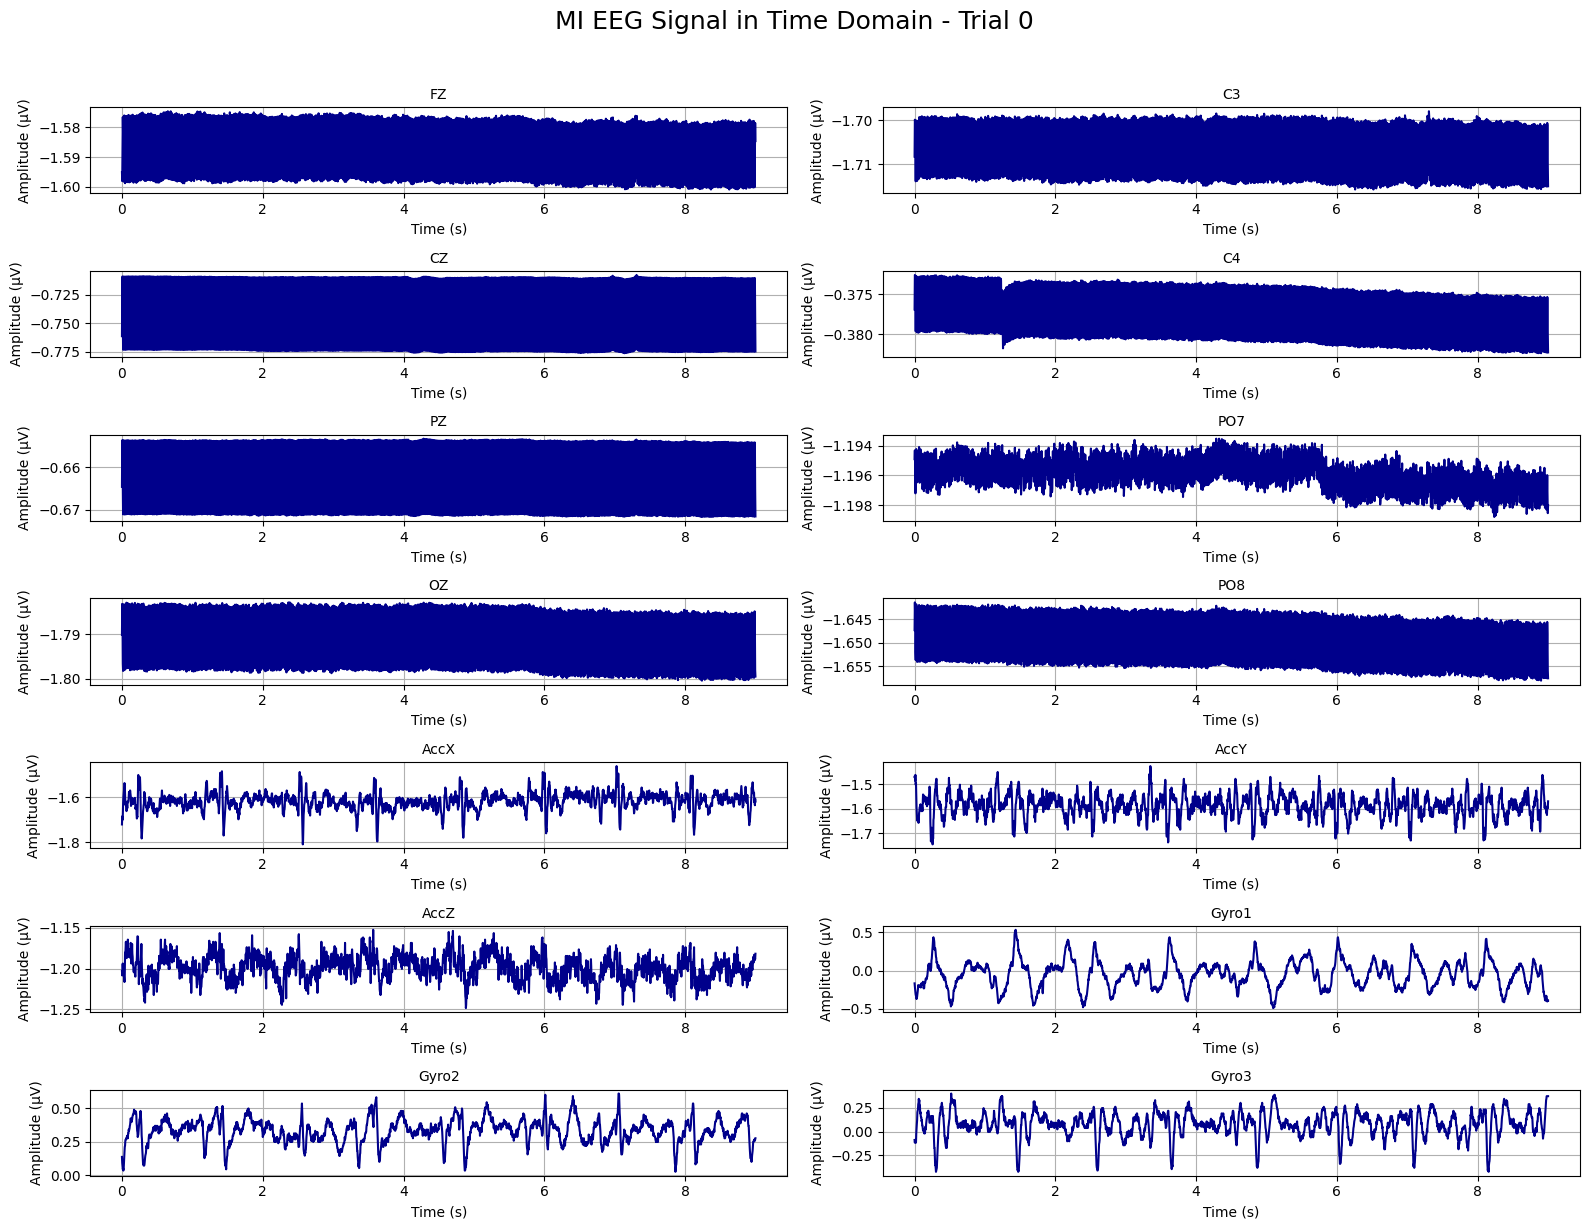

In [26]:
sample_idx = 0
sample = X_train[sample_idx]  
time = np.linspace(0, 2250 / 250, 2250)  

plt.figure(figsize=(16, 12))
for i in range(sample.shape[1]):
    plt.subplot(7, 2, i + 1)
    plt.plot(time, sample[:, i], color='darkblue')
    plt.title(feature_columns[i], fontsize=10)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.grid(True)

plt.suptitle("MI EEG Signal in Time Domain - Trial 0", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## MI Feature Extraction

In [27]:
mi_freqs = [10, 13]
def extract_features_from_sequence(seq):
    features = {}
    for i in range(seq.shape[1]):
        channel = seq[:, i]
        features[f'ch{i}_mean'] = np.mean(channel)
        features[f'ch{i}_std'] = np.std(channel)
        features[f'ch{i}_min'] = np.min(channel)
        features[f'ch{i}_max'] = np.max(channel)
        features[f'ch{i}_median'] = np.median(channel)
        features[f'ch{i}_range'] = np.ptp(channel)
        features[f'ch{i}_energy'] = np.sum(channel**2)
        features[f'ch{i}_skew'] = skew(channel)
        features[f'ch{i}_kurtosis'] = kurtosis(channel)
        features[f'ch{i}_zcr'] = ((np.diff(np.sign(channel)) != 0).sum()) / len(channel)
    return features

def extract_fft_features(seq):
    features = {}
    for i in range(seq.shape[1]):
        channel = seq[:, i]
        fft_vals = np.fft.rfft(channel)
        fft_power = np.abs(fft_vals) ** 2
        features[f'ch{i}_fft_mean'] = np.mean(fft_power)
        features[f'ch{i}_fft_std'] = np.std(fft_power)
        features[f'ch{i}_fft_max'] = np.max(fft_power)
        features[f'ch{i}_fft_freq_max'] = np.argmax(fft_power)
    return features

def extract_wavelet_features(seq):
    features = {}
    for i in range(seq.shape[1]):
        coeffs = pywt.wavedec(seq[:, i], 'db4', level=3)
        for j, c in enumerate(coeffs):
            features[f'ch{i}_w{j}_mean'] = np.mean(c)
            features[f'ch{i}_w{j}_std'] = np.std(c)
    return features

def extract_target_freq_power(seq, fs, target_freqs):
    features = {}
    n = seq.shape[0]
    freqs = np.fft.rfftfreq(n, d=1/fs)
    window = np.hanning(n)
    
    for i in range(seq.shape[1]):
        windowed_signal = seq[:, i] * window
        fft_vals = np.fft.rfft(windowed_signal)
        power = np.abs(fft_vals) ** 2
        
        for f in target_freqs:
            idx_range = np.where((freqs >= f-0.5) & (freqs <= f+0.5))[0]
            if len(idx_range) > 0:
                features[f'ch{i}_power_{f}Hz'] = np.mean(power[idx_range])
                features[f'ch{i}_power_{f}Hz_peak'] = np.max(power[idx_range])
    return features

def extract_mi_power_features(seq, fs=250):
    features = {}
    n = seq.shape[0]
    
    mi_channels = ['C3', 'C4', 'CZ']
    channel_indices = [feature_columns.index(ch) for ch in mi_channels if ch in feature_columns]
    
    for i in channel_indices:
        f, pxx = welch(seq[:, i], fs=fs, nperseg=min(256, n))
        
        for freq in mi_freqs:
            idx = np.argmin(np.abs(f - freq))
            features[f'ch{i}_{freq}Hz_power'] = pxx[idx]
            
            neighbors = np.where((f >= freq-2) & (f <= freq+2) & (np.abs(f - freq) > 0.5))[0]
            if len(neighbors) > 0:
                neighbor_power = np.mean(pxx[neighbors])
                features[f'ch{i}_{freq}Hz_ratio'] = pxx[idx] / (neighbor_power + 1e-10)
    
    return features

def extract_combined_mi_features(seq, fs=250):
    
    features = extract_features_from_sequence(seq)
    features.update(extract_fft_features(seq))
    features.update(extract_wavelet_features(seq))
    features.update(extract_target_freq_power(seq, fs, mi_freqs))
    features.update(extract_mi_power_features(seq, fs)) 
    return features

def transform_sequences(X):
    feature_list = [extract_combined_mi_features(seq) for seq in X]
    return pd.DataFrame(feature_list)

In [28]:
scaler = StandardScaler()
X_train = transform_sequences(X_train)
X_train = scaler.fit_transform(X_train)
print("✅ X_train shape:", X_train.shape)
print("✅ y_train shape:", y_train.shape)

✅ X_train shape: (720, 376)
✅ y_train shape: (720,)


In [29]:
X_val = transform_sequences(X_val)
X_val = scaler.transform(X_val)
print("✅ X_val shape:", X_val.shape)
print("✅ y_val shape:", y_val.shape)

✅ X_val shape: (50, 376)
✅ y_val shape: (50,)


In [30]:
X_test = transform_sequences(X_test)
X_test = scaler.transform(X_test)
print("✅ X_test shape:", X_test.shape)

✅ X_test shape: (50, 376)


## MI Data Visualization

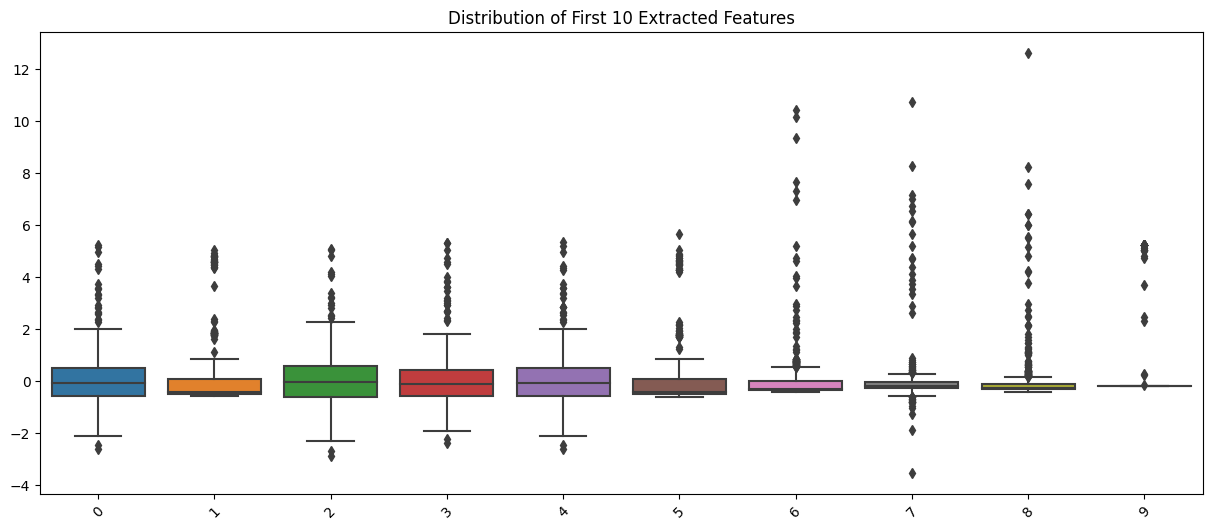

In [31]:
X_train_df = pd.DataFrame(X_train)  
plt.figure(figsize=(15, 6))
X_sampled = X_train_df.iloc[:, :10]

sns.boxplot(data=X_sampled)
plt.xticks(rotation=45)
plt.title("Distribution of First 10 Extracted Features")
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


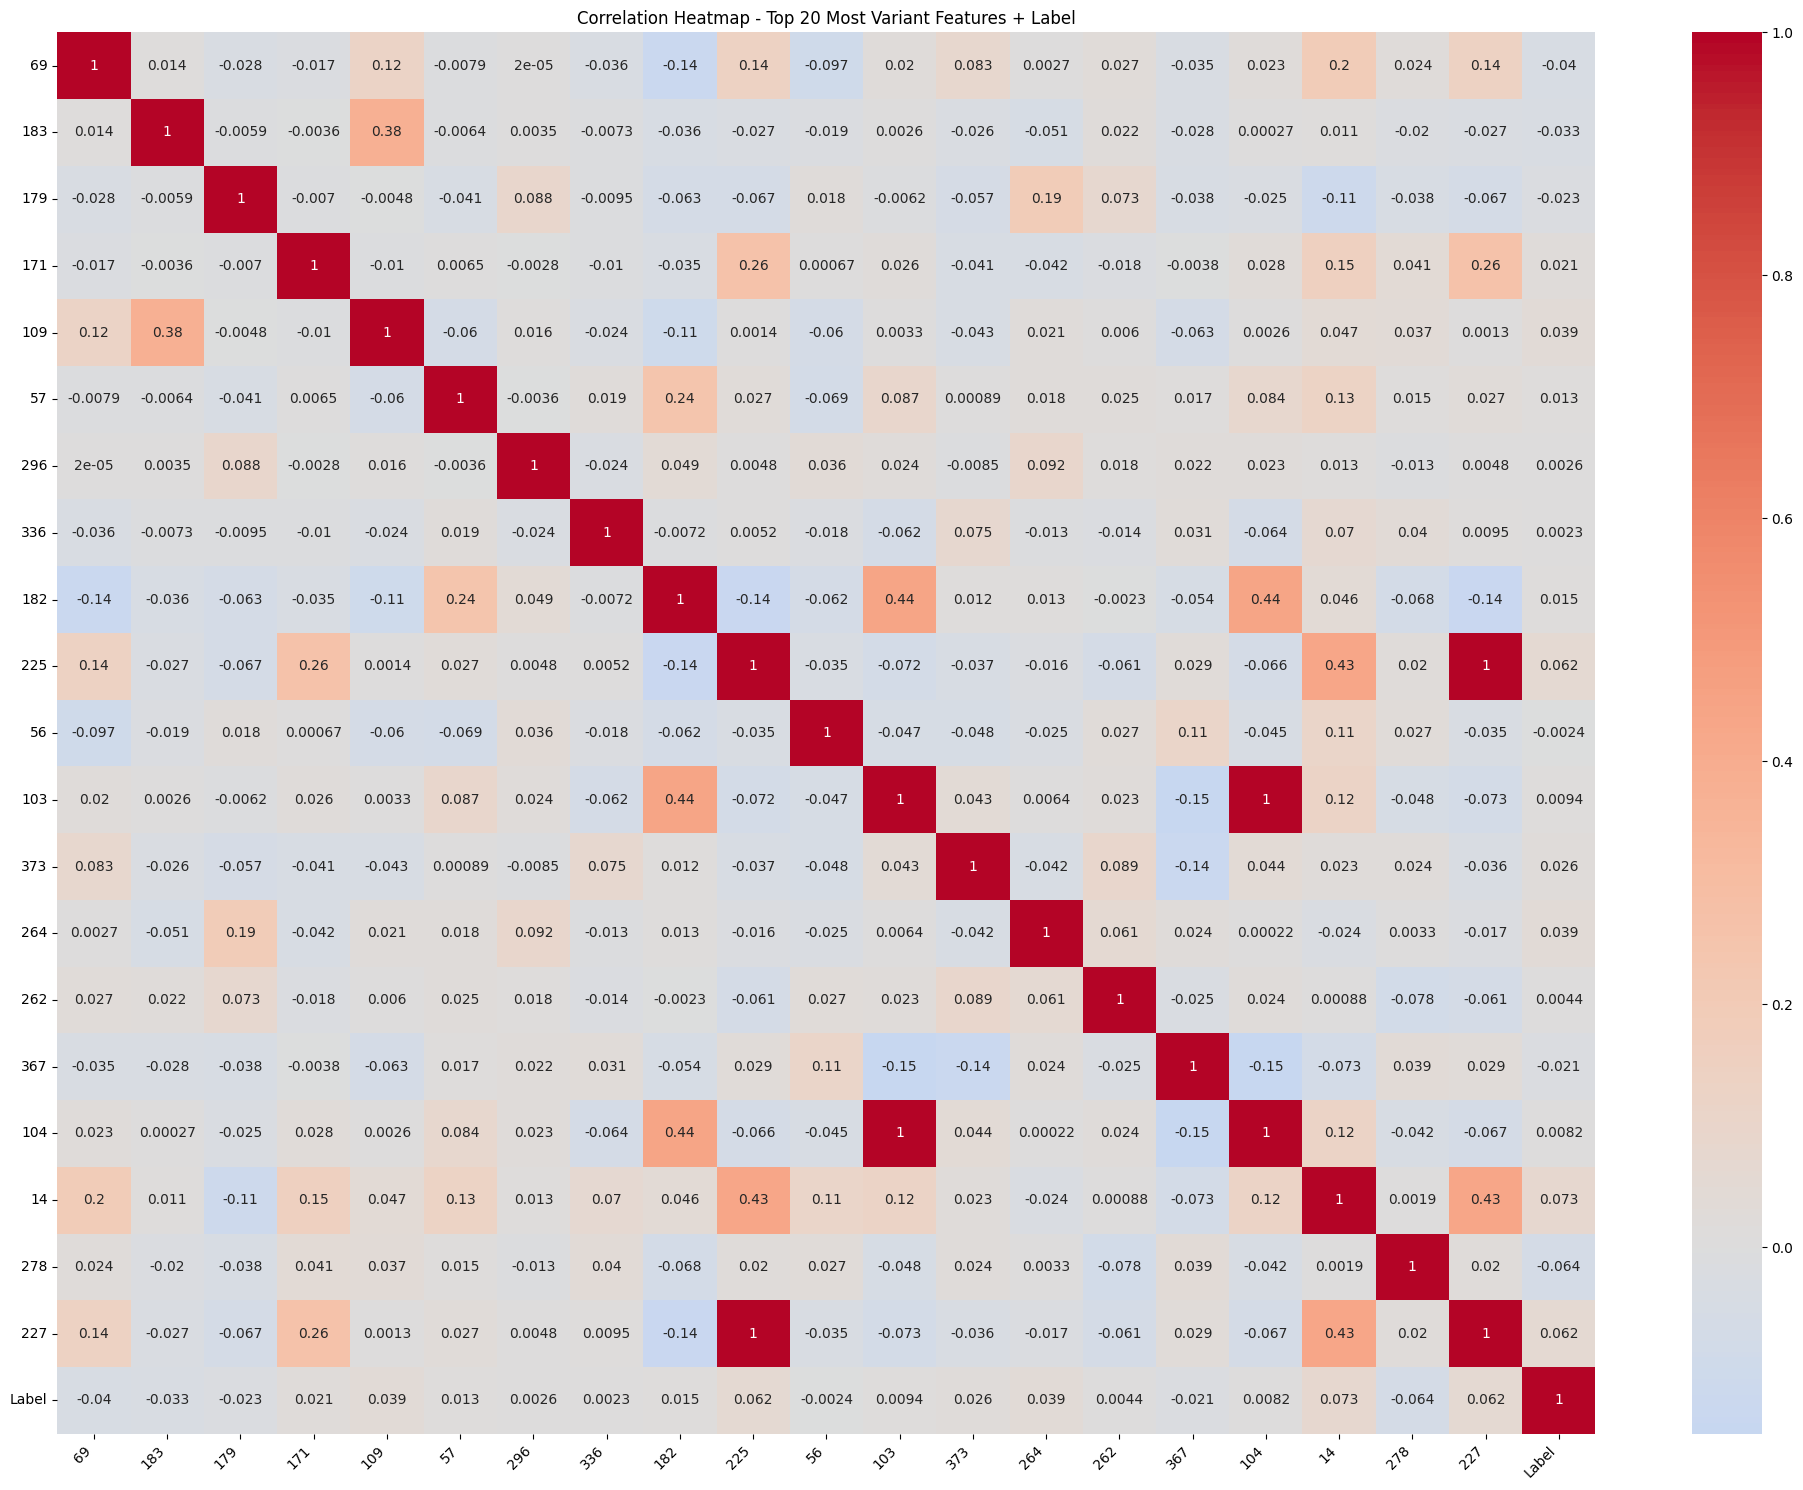

In [32]:
variances = X_train_df.var().sort_values(ascending=False)

top_features = variances.head(20).index.tolist()

X_corr_with_target = X_train_df[top_features].copy()
X_corr_with_target['Label'] = y_train 

plt.figure(figsize=(20, 15))
sns.heatmap(X_corr_with_target.corr(), cmap='coolwarm', center=0, annot=True)
plt.title("Correlation Heatmap - Top 20 Most Variant Features + Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

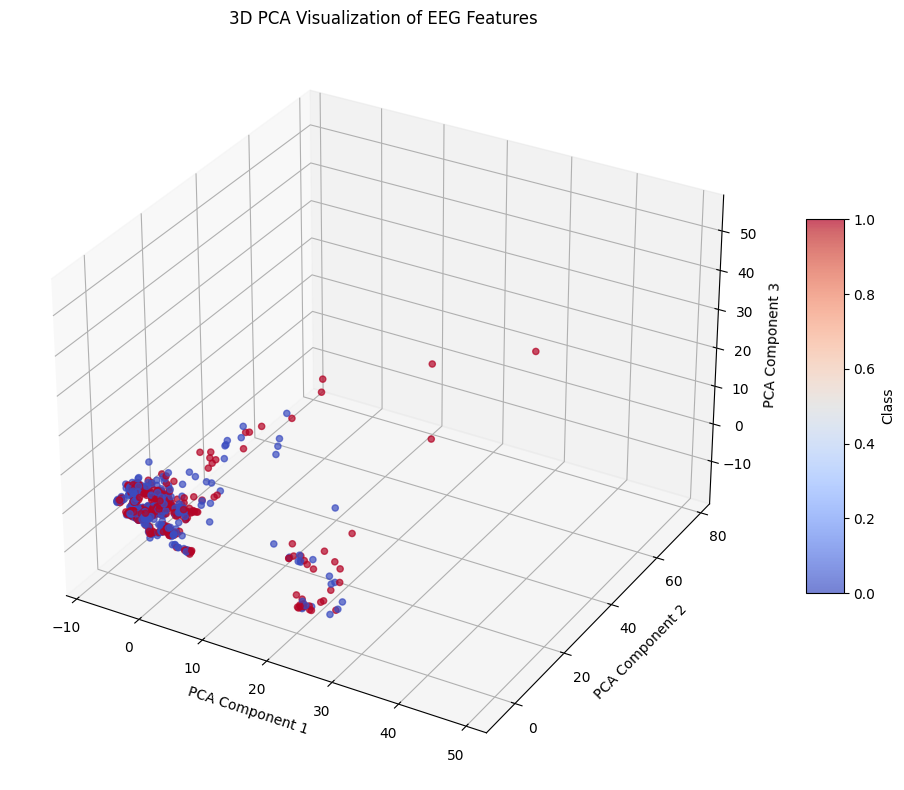

In [33]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=y_train, cmap='coolwarm', alpha=0.7)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Visualization of EEG Features')

legend = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
legend.set_label('Class')

plt.tight_layout()
plt.show()

## MI Data Augmentation

In [34]:
def balanced_augmentation(X, y, target_samples_per_class=None, seed=42):
    np.random.seed(seed)
    unique_classes, class_counts = np.unique(y, return_counts=True)
    if target_samples_per_class is None:
        target_samples_per_class = max(class_counts)

    X_aug = []
    y_aug = []

    for label in unique_classes:
        class_indices = np.where(y == label)[0]
        X_class = X[class_indices]
        y_class = y[class_indices]
        current_count = len(X_class)

        X_aug.append(X_class)
        y_aug.append(y_class)

        if current_count < target_samples_per_class:
            n_needed = target_samples_per_class - current_count
            sample_indices = np.random.choice(current_count, n_needed, replace=True)
            noisy_samples = X_class[sample_indices] + np.random.normal(0, 0.01, size=X_class[sample_indices].shape)
            X_aug.append(noisy_samples)
            y_aug.append(np.full(n_needed, label))

    X_bal = np.vstack(X_aug)
    y_bal = np.hstack(y_aug)

    indices = np.random.permutation(len(X_bal))
    return X_bal[indices], y_bal[indices]

In [35]:
X_train, y_train = balanced_augmentation(X_train, y_train)

In [36]:
print("✅ X_train shape:", X_train.shape)
print("✅ X_val shape:", X_val.shape)
print("✅ y_train shape:", y_train.shape)
print("✅ y_val shape:", y_val.shape)

✅ X_train shape: (728, 376)
✅ X_val shape: (50, 376)
✅ y_train shape: (728,)
✅ y_val shape: (50,)


## Building & Training MI Model

In [37]:
base_MI_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
base_MI_model.fit(X_train, y_train)

importances = base_MI_model.feature_importances_
top_k = 100
indices = np.argsort(importances)[::-1][:top_k]

if isinstance(X_train, np.ndarray):
    X_train_selected = X_train[:, indices]
else:
    X_train_selected = X_train.to_numpy()[:, indices]

if isinstance(X_val, np.ndarray):
    X_val_selected = X_val[:, indices]
else:
    X_val_selected = X_val.to_numpy()[:, indices]

if isinstance(X_test, np.ndarray):
    X_test = X_test[:, indices]
else:
    X_test = X_test.to_numpy()[:, indices]
    
print("✅ Selected features shape:", X_train_selected.shape)

✅ Selected features shape: (728, 100)


In [38]:
np.save("top100_indices.npy", indices)

In [39]:
X_combined = np.vstack((X_train_selected, X_val_selected))
y_combined = np.hstack((y_train, y_val))

In [40]:
xgb_model_MI = XGBClassifier(
    n_estimators=550,
    learning_rate=0.03,
    max_depth=1,                 
    subsample=0.7,                
    colsample_bytree=0.5,         
    min_child_weight=4,
    reg_alpha=1,
    eval_metric='logloss',
    random_state=42
)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model_MI, X_combined, y_combined, cv=kf, scoring='accuracy')
print("Mean CV Accuracy:", scores.mean())

xgb_model_MI.fit(X_combined, y_combined)

y_train_pred = xgb_model_MI.predict(X_combined)
y_val_pred = xgb_model_MI.predict(X_val_selected)

print("Train Accuracy:", accuracy_score(y_combined, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred, digits=4))

Mean CV Accuracy: 0.5874458874458874
Train Accuracy: 0.781491002570694
Validation Accuracy: 0.76

Confusion Matrix:
 [[22  6]
 [ 6 16]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7857    0.7857    0.7857        28
           1     0.7273    0.7273    0.7273        22

    accuracy                         0.7600        50
   macro avg     0.7565    0.7565    0.7565        50
weighted avg     0.7600    0.7600    0.7600        50



In [41]:
joblib.dump(xgb_model_MI, 'MI_Model.pkl')

['MI_Model.pkl']

## Saving MI Predictions

In [42]:
y_probs = xgb_model_MI.predict_proba(X_test)[:, 1]
y_preds = (y_probs > 0.5).astype(int)

In [43]:
df_predictions_MI = pd.DataFrame({
    'id':  range(4901, 4901 + len(y_preds)),
    'label': y_preds
})

In [44]:
df_predictions_MI

,id,label
0,4901,0
1,4902,1
2,4903,1
3,4904,1
4,4905,1
5,4906,0
6,4907,0
7,4908,0
8,4909,1
9,4910,1


In [45]:
df_predictions_MI['label'].value_counts()

label
0    26
1    24
Name: count, dtype: int64

***

# 👁️ Part 2: Steady-State Visual Evoked Potentials (SSVEP) Classification

___

## Loading & Display SSVEP Data

In [46]:
base_path_train = '/kaggle/input/mtcaic3/SSVEP/train'
base_path_valid = '/kaggle/input/mtcaic3/SSVEP/validation'
base_path_test  = '/kaggle/input/mtcaic3/SSVEP/test'
df_train = load_eeg_data(subject_range=range(1, 31), session_range=range(1, 9), base_path=base_path_train, dataset_type='train')
df_valid = load_eeg_data(subject_range=range(31, 36), session_range=None, base_path=base_path_valid, dataset_type='valid')
df_test  = load_eeg_data(subject_range=range(36, 41), session_range=None, base_path=base_path_test, dataset_type='test')

In [47]:
df_SSVEP = pd.concat([df_train, df_valid, df_test], ignore_index=True)
df_SSVEP.head() 

,Time,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Battery,Counter,Validation,Subject,Session
0,469033.913193,258287.656250,264789.31250,280744.62500,264021.84375,258592.968750,255182.093750,229271.875000,245442.546875,-0.113525,0.828857,-0.555664,-0.701904,1.708984,0.732422,100.0,66617.0,1.0,S1,1.0
1,469033.913220,259057.625000,264991.46875,279824.28125,263310.53125,257506.234375,255150.187500,228774.937500,245187.656250,-0.114990,0.828613,-0.558594,-0.671387,1.708984,0.823975,100.0,66618.0,1.0,S1,1.0
2,469033.913222,259117.703125,264636.09375,276138.75000,262477.34375,255673.484375,255143.203125,228390.046875,245012.593750,-0.114990,0.827148,-0.558594,-0.579834,1.861572,0.823975,100.0,66619.0,1.0,S1,1.0
3,469033.913224,258451.265625,264274.34375,274926.75000,262635.34375,255619.656250,255160.015625,228623.937500,245139.734375,-0.114258,0.827881,-0.561523,-0.457764,1.800537,0.854492,100.0,66620.0,1.0,S1,1.0
4,469033.915669,257968.921875,264438.06250,278104.53125,263602.71875,257495.062500,255195.515625,229186.578125,245414.484375,-0.113281,0.825439,-0.561279,-0.335693,1.800537,0.793457,100.0,66621.0,1.0,S1,1.0


In [48]:
df_SSVEP = df_SSVEP.drop(["Time","Battery","Counter"],axis=1)

## SSVEP Data Preprocessing

In [49]:
df_SSVEP["Session"]=df_SSVEP["Session"].fillna(0)

In [50]:
df_SSVEP = df_SSVEP.copy()
columns_to_exclude = ['Validation', 'Session', 'Subject'] 
columns_to_clip = [col for col in df_SSVEP.columns if col not in columns_to_exclude and np.issubdtype(df_SSVEP[col].dtype, np.number)]

min_values = df_SSVEP[df_SSVEP['Validation'] == 1][columns_to_clip].min()
max_values = df_SSVEP[df_SSVEP['Validation'] == 1][columns_to_clip].max()

for col in columns_to_clip:
    mask = df_SSVEP['Validation'] == 0
    df_SSVEP.loc[mask, col] = df_SSVEP.loc[mask, col].clip(lower=min_values[col], upper=max_values[col])

df_SSVEP.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Validation,Subject,Session
0,258287.656250,264789.31250,280744.62500,264021.84375,258592.968750,255182.093750,229271.875000,245442.546875,-0.113525,0.828857,-0.555664,-0.701904,1.708984,0.732422,1.0,S1,1.0
1,259057.625000,264991.46875,279824.28125,263310.53125,257506.234375,255150.187500,228774.937500,245187.656250,-0.114990,0.828613,-0.558594,-0.671387,1.708984,0.823975,1.0,S1,1.0
2,259117.703125,264636.09375,276138.75000,262477.34375,255673.484375,255143.203125,228390.046875,245012.593750,-0.114990,0.827148,-0.558594,-0.579834,1.861572,0.823975,1.0,S1,1.0
3,258451.265625,264274.34375,274926.75000,262635.34375,255619.656250,255160.015625,228623.937500,245139.734375,-0.114258,0.827881,-0.561523,-0.457764,1.800537,0.854492,1.0,S1,1.0
4,257968.921875,264438.06250,278104.53125,263602.71875,257495.062500,255195.515625,229186.578125,245414.484375,-0.113281,0.825439,-0.561279,-0.335693,1.800537,0.793457,1.0,S1,1.0


In [51]:
feature_columns = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8', 'AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']

In [52]:
noise_columns = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
df_best = select_low_noise_experiments(df_SSVEP, noise_columns, top_n=10,exp_length=1750)

print("✅ Best low-noise experiments:")
print(df_best[['Subject', 'Session', 'Experiment']].drop_duplicates().sort_values(['Subject', 'Session']).head(10))

print(f"Shape of selected data: {df_best.shape}")

✅ Best low-noise experiments:
      Subject  Session  Experiment
0          S1      1.0           1
1750       S1      1.0           2
3500       S1      1.0           3
5250       S1      1.0           4
7000       S1      1.0           5
8750       S1      1.0           6
10500      S1      1.0           7
12250      S1      1.0           8
14000      S1      1.0           9
15750      S1      1.0          10
Shape of selected data: (4200000, 19)


In [53]:
left_keys = ["Subject", "Session", "Experiment"]
right_keys = ["subject_id", "trial_session", "trial"]

df_merged_train, X_train = merge(df_best, df_train_labels_SSVEP, left_keys, right_keys, feature_columns, group_size=1750)
print("✅ X_train shape:", X_train.shape)

✅ X_train shape: (2400, 1750, 14)


In [54]:
df_merged_train.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,...,Subject,Session,Experiment,avg_noise,id,subject_id,task,trial_session,trial,label
0,258287.656250,264789.31250,280744.62500,264021.84375,258592.968750,255182.093750,229271.875000,245442.546875,-0.113525,0.828857,...,S1,1,1,0.12382,2401,S1,SSVEP,1,1,Forward
1,259057.625000,264991.46875,279824.28125,263310.53125,257506.234375,255150.187500,228774.937500,245187.656250,-0.114990,0.828613,...,S1,1,1,0.12382,2401,S1,SSVEP,1,1,Forward
2,259117.703125,264636.09375,276138.75000,262477.34375,255673.484375,255143.203125,228390.046875,245012.593750,-0.114990,0.827148,...,S1,1,1,0.12382,2401,S1,SSVEP,1,1,Forward
3,258451.265625,264274.34375,274926.75000,262635.34375,255619.656250,255160.015625,228623.937500,245139.734375,-0.114258,0.827881,...,S1,1,1,0.12382,2401,S1,SSVEP,1,1,Forward
4,257968.921875,264438.06250,278104.53125,263602.71875,257495.062500,255195.515625,229186.578125,245414.484375,-0.113281,0.825439,...,S1,1,1,0.12382,2401,S1,SSVEP,1,1,Forward


In [55]:
df_sess0 = df_SSVEP[df_SSVEP['Session'] == 0].copy()
mid = len(df_sess0) // 2

df_valid_p = df_sess0.iloc[:mid].copy()
df_test_p  = df_sess0.iloc[mid:].copy()

for df_part in [df_valid_p, df_test_p]:
    df_part['Experiment'] = df_part.groupby(['Subject', 'Session']).cumcount() // 1750 + 1

In [56]:
left_keys = ["Subject", "Experiment"]
right_keys = ["subject_id", "trial"]

df_merged_valid, X_val = merge(df_valid_p, df_valid_labels_SSVEP, left_keys, right_keys, feature_columns, group_size=1750)
print("✅ X_valid shape:", X_val.shape)

✅ X_valid shape: (50, 1750, 14)


In [57]:
df_merged_test, X_test = merge(df_test_p, df_test_labels_SSVEP, left_keys, right_keys, feature_columns, group_size=1750)
print("✅ X_test shape:", X_test.shape)

✅ X_test shape: (50, 1750, 14)


In [58]:
df_merged_valid.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,...,Validation,Subject,Session,Experiment,id,subject_id,task,trial_session,trial,label
0,324902.18750,385996.84375,432558.65625,409734.31250,365923.46875,317058.43750,300285.68750,335185.34375,-0.008545,0.878662,...,1.0,S31,0.0,1,4851,S31,SSVEP,1,1,Backward
1,317818.40625,378005.84375,418195.71875,403046.84375,358047.59375,309845.81250,295028.18750,330860.46875,-0.001465,0.881592,...,1.0,S31,0.0,1,4851,S31,SSVEP,1,1,Backward
2,309207.15625,363968.50000,396092.40625,394687.84375,347218.62500,301489.09375,289328.50000,325276.09375,0.001709,0.882812,...,1.0,S31,0.0,1,4851,S31,SSVEP,1,1,Backward
3,311014.34375,363687.40625,396949.03125,396249.34375,348574.12500,303549.31250,291094.03125,326215.50000,0.006836,0.882568,...,1.0,S31,0.0,1,4851,S31,SSVEP,1,1,Backward
4,320529.12500,377661.25000,419408.68750,405447.53125,360312.28125,313062.84375,297836.37500,332374.65625,0.010010,0.883301,...,1.0,S31,0.0,1,4851,S31,SSVEP,1,1,Backward


In [59]:
df_merged_test.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,...,Gyro3,Validation,Subject,Session,Experiment,id,subject_id,task,trial_session,trial
0,312348.03125,326070.03125,356139.84375,327908.59375,345758.34375,310025.06250,300096.68750,320054.09375,-0.062500,0.860840,...,0.518799,1.0,S36,0.0,1,4951,S36,SSVEP,1,1
1,318959.21875,332422.03125,366345.37500,333958.25000,351259.46875,313999.81250,303043.43750,322055.84375,-0.063721,0.860352,...,0.610352,1.0,S36,0.0,1,4951,S36,SSVEP,1,1
2,335669.46875,343516.18750,386262.21875,343711.09375,359949.65625,317322.53125,305780.00000,323803.21875,-0.063477,0.860107,...,0.762939,1.0,S36,0.0,1,4951,S36,SSVEP,1,1
3,339715.50000,344192.03125,388600.65625,343820.00000,359886.87500,315451.15625,304557.03125,322897.68750,-0.063965,0.862793,...,0.823975,1.0,S36,0.0,1,4951,S36,SSVEP,1,1
4,325225.75000,333395.31250,370017.40625,334061.59375,351143.50000,310926.28125,301043.40625,320569.53125,-0.062500,0.863525,...,0.885010,1.0,S36,0.0,1,4951,S36,SSVEP,1,1


In [60]:
label_map = {'left': 0, 'right': 1, 'forward': 2, 'backward': 3}
y_train = np.array([label_map[label.lower()] for label in df_merged_train['label'].values[::1750]])
y_val = np.array([label_map[label.lower()] for label in df_merged_valid['label'].values[::1750]])

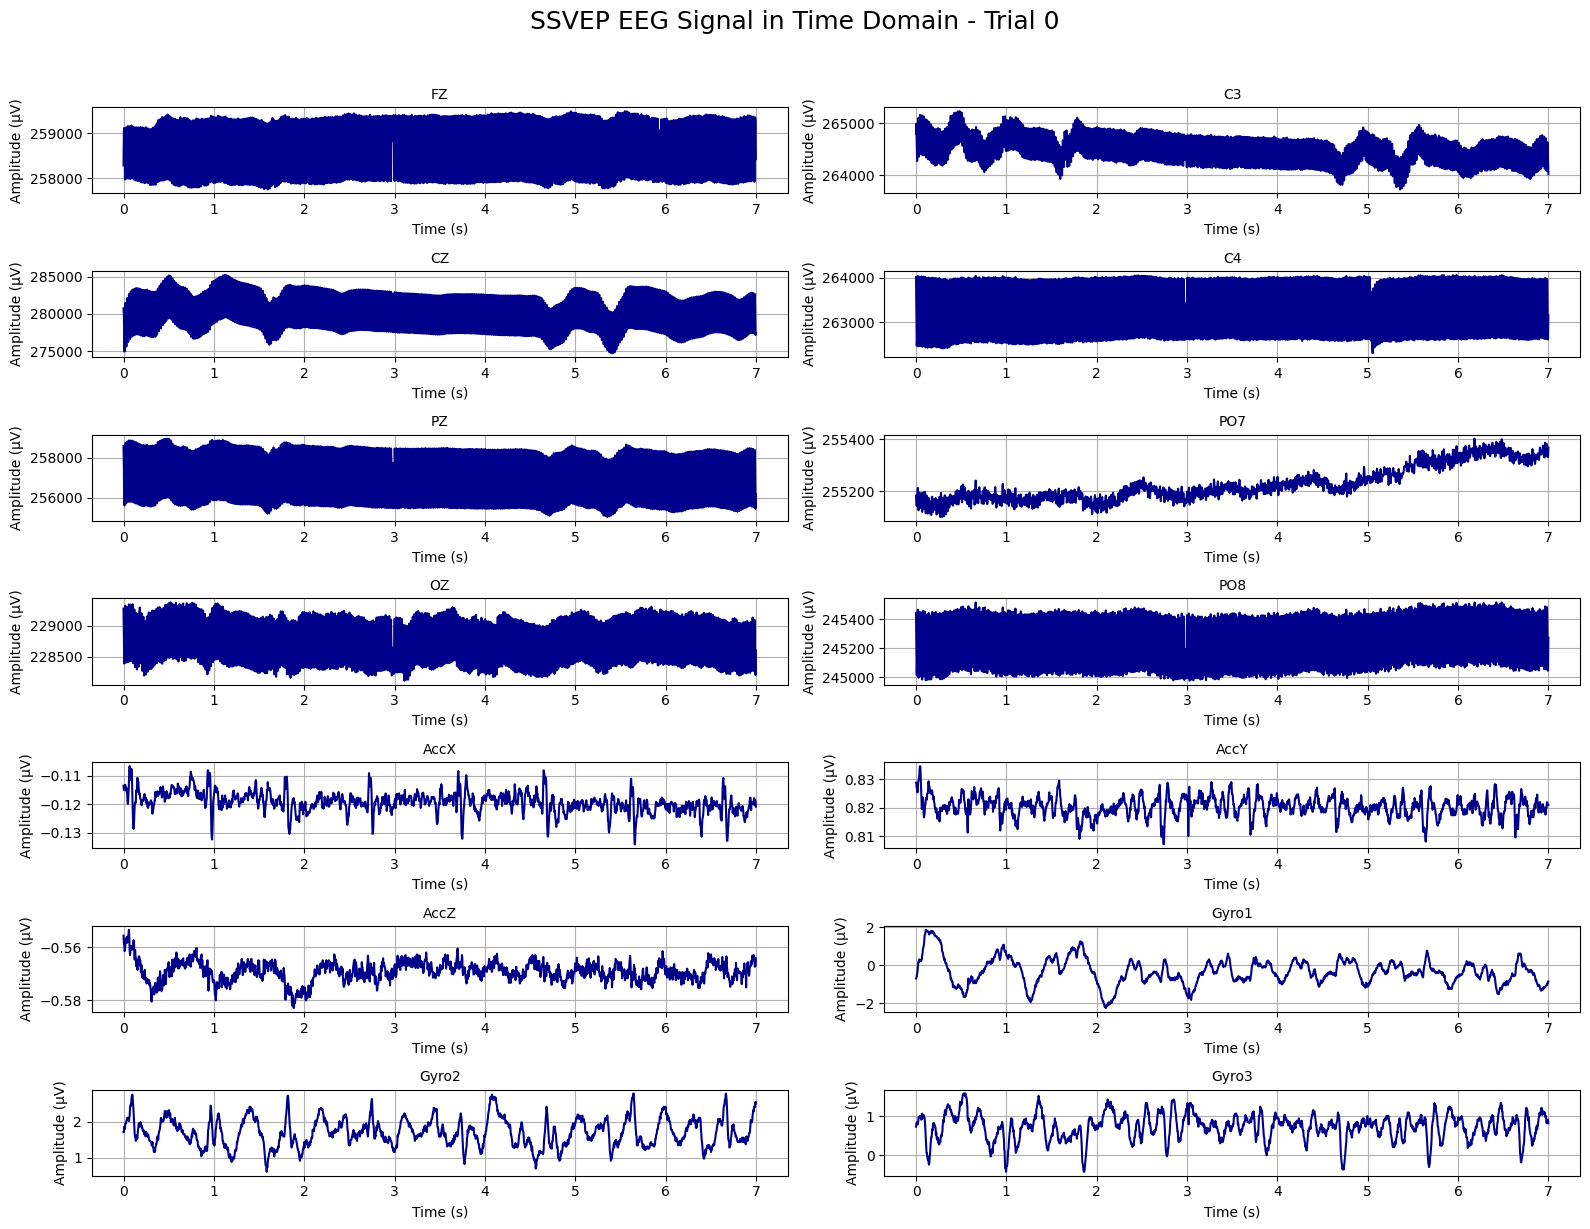

In [61]:
sample_idx = 0
sample = X_train[sample_idx]  
time = np.linspace(0, 1750 / 250, 1750)  

plt.figure(figsize=(16, 12))
for i in range(sample.shape[1]):
    plt.subplot(7, 2, i + 1)
    plt.plot(time, sample[:, i], color='darkblue')
    plt.title(feature_columns[i], fontsize=10)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.grid(True)

plt.suptitle("SSVEP EEG Signal in Time Domain - Trial 0", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## SSVEP Feature Extraction

In [62]:
target_freqs = [7, 8, 10, 13] 
fs = 250  

def extract_features_from_sequence(seq):
    features = {}
    for i in range(seq.shape[1]):
        channel = seq[:, i]
        features[f'ch{i}_mean'] = np.mean(channel)
        features[f'ch{i}_std'] = np.std(channel)
        features[f'ch{i}_min'] = np.min(channel)
        features[f'ch{i}_max'] = np.max(channel)
        features[f'ch{i}_median'] = np.median(channel)
        features[f'ch{i}_range'] = np.ptp(channel)
        features[f'ch{i}_energy'] = np.sum(channel**2)
        features[f'ch{i}_skew'] = skew(channel)
        features[f'ch{i}_kurtosis'] = kurtosis(channel)
        features[f'ch{i}_zcr'] = ((np.diff(np.sign(channel)) != 0).sum()) / len(channel)
    return features

def extract_fft_features(seq):
    features = {}
    for i in range(seq.shape[1]):
        channel = seq[:, i]
        fft_vals = np.fft.rfft(channel)
        fft_power = np.abs(fft_vals) ** 2
        features[f'ch{i}_fft_mean'] = np.mean(fft_power)
        features[f'ch{i}_fft_std'] = np.std(fft_power)
        features[f'ch{i}_fft_max'] = np.max(fft_power)
        features[f'ch{i}_fft_freq_max'] = np.argmax(fft_power)
    return features

def extract_wavelet_features(seq):
    features = {}
    for i in range(seq.shape[1]):
        coeffs = pywt.wavedec(seq[:, i], 'db4', level=3)
        for j, c in enumerate(coeffs):
            features[f'ch{i}_w{j}_mean'] = np.mean(c)
            features[f'ch{i}_w{j}_std'] = np.std(c)
    return features

def extract_target_freq_power(seq, fs, target_freqs):
    features = {}
    n = seq.shape[0]
    freqs = np.fft.rfftfreq(n, d=1/fs)
    
    window = np.hanning(n)
    
    for i in range(seq.shape[1]):
        windowed_signal = seq[:, i] * window
        fft_vals = np.fft.rfft(windowed_signal)
        power = np.abs(fft_vals) ** 2
        
        for f in target_freqs:
            idx_range = np.where((freqs >= f-0.5) & (freqs <= f+0.5))[0]
            if len(idx_range) > 0:
                features[f'ch{i}_power_{f}Hz'] = np.mean(power[idx_range])
                features[f'ch{i}_power_{f}Hz_peak'] = np.max(power[idx_range])
                
    return features

def extract_ssvep_features(seq, fs=250):
    features = {}
    n = seq.shape[0]
    
    ssvep_freqs = {
        'left': 10,      
        'right': 13,     
        'forward': 7,    
        'backward': 8    
    }
    
    ssvep_channels = ['PZ', 'PO7', 'OZ', 'PO8']
    channel_indices = [feature_columns.index(ch) for ch in ssvep_channels if ch in feature_columns]
    
    for i in channel_indices:
        f, pxx = welch(seq[:, i], fs=fs, nperseg=min(256, n))
        
        for label, freq in ssvep_freqs.items():
            idx = np.argmin(np.abs(f - freq))
            features[f'ch{i}_{label}_power'] = pxx[idx]
            
            neighbor_indices = np.where((f >= freq-2) & (f <= freq+2) & (np.abs(f - freq) > 0.5))[0]
            if len(neighbor_indices) > 0:
                neighbor_power = np.mean(pxx[neighbor_indices])
                features[f'ch{i}_{label}_power_ratio'] = pxx[idx] / (neighbor_power + 1e-10)
    
    return features

def extract_combined_features(seq, fs=250):
    features = extract_features_from_sequence(seq)
    features.update(extract_fft_features(seq))
    features.update(extract_wavelet_features(seq))
    features.update(extract_target_freq_power(seq, fs, [7, 8, 10, 13]))
    features.update(extract_ssvep_features(seq, fs))  
    return features

def transform_sequences(X):
    feature_list = [extract_combined_features(seq) for seq in X]
    return pd.DataFrame(feature_list)

In [63]:
def bandpass_filter(data, lowcut=5, highcut=40, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def preprocess_eeg_data(X, feature_columns):
    eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    eeg_indices = [feature_columns.index(ch) for ch in eeg_channels if ch in feature_columns]
    
    X_processed = X.copy()
    
    for i in range(X.shape[0]):
        for j in eeg_indices:
            X_processed[i, :, j] = bandpass_filter(X[i, :, j], 5, 40)
            
            X_processed[i, :, j] = bandpass_filter(X[i, :, j], 6, 15)
    
    return X_processed

In [64]:
scaler = StandardScaler()
X_train = preprocess_eeg_data(X_train, feature_columns)
X_train = transform_sequences(X_train)
X_train = scaler.fit_transform(X_train)
print("✅ X_train shape:", X_train.shape)
print("✅ y_train shape:", y_train.shape)

✅ X_train shape: (2400, 452)
✅ y_train shape: (2400,)


In [65]:
X_val = preprocess_eeg_data(X_val, feature_columns)
X_val = transform_sequences(X_val)
X_val = scaler.transform(X_val)
print("✅ X_val shape:", X_val.shape)
print("✅ y_val shape:", y_val.shape)

✅ X_val shape: (50, 452)
✅ y_val shape: (50,)


In [66]:
X_test = preprocess_eeg_data(X_test, feature_columns)
X_test = transform_sequences(X_test)
X_test = scaler.transform(X_test)
print("✅ X_test shape:", X_test.shape)

✅ X_test shape: (50, 452)


## SSVEP Data Visualization

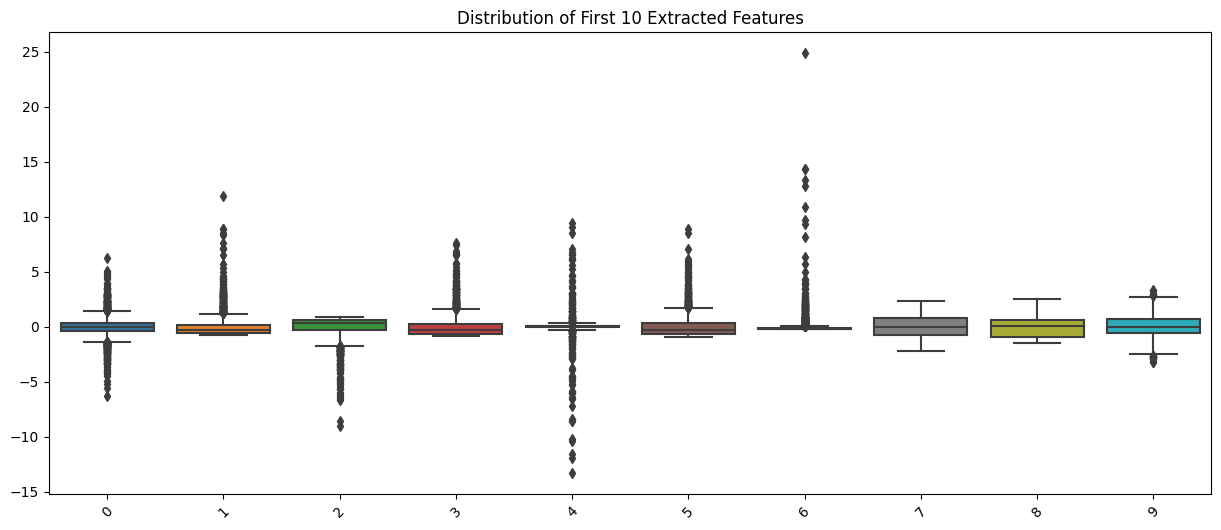

In [67]:
X_train_df = pd.DataFrame(X_train)  
plt.figure(figsize=(15, 6))
X_sampled = X_train_df.iloc[:, :10]

sns.boxplot(data=X_sampled)
plt.xticks(rotation=45)
plt.title("Distribution of First 10 Extracted Features")
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


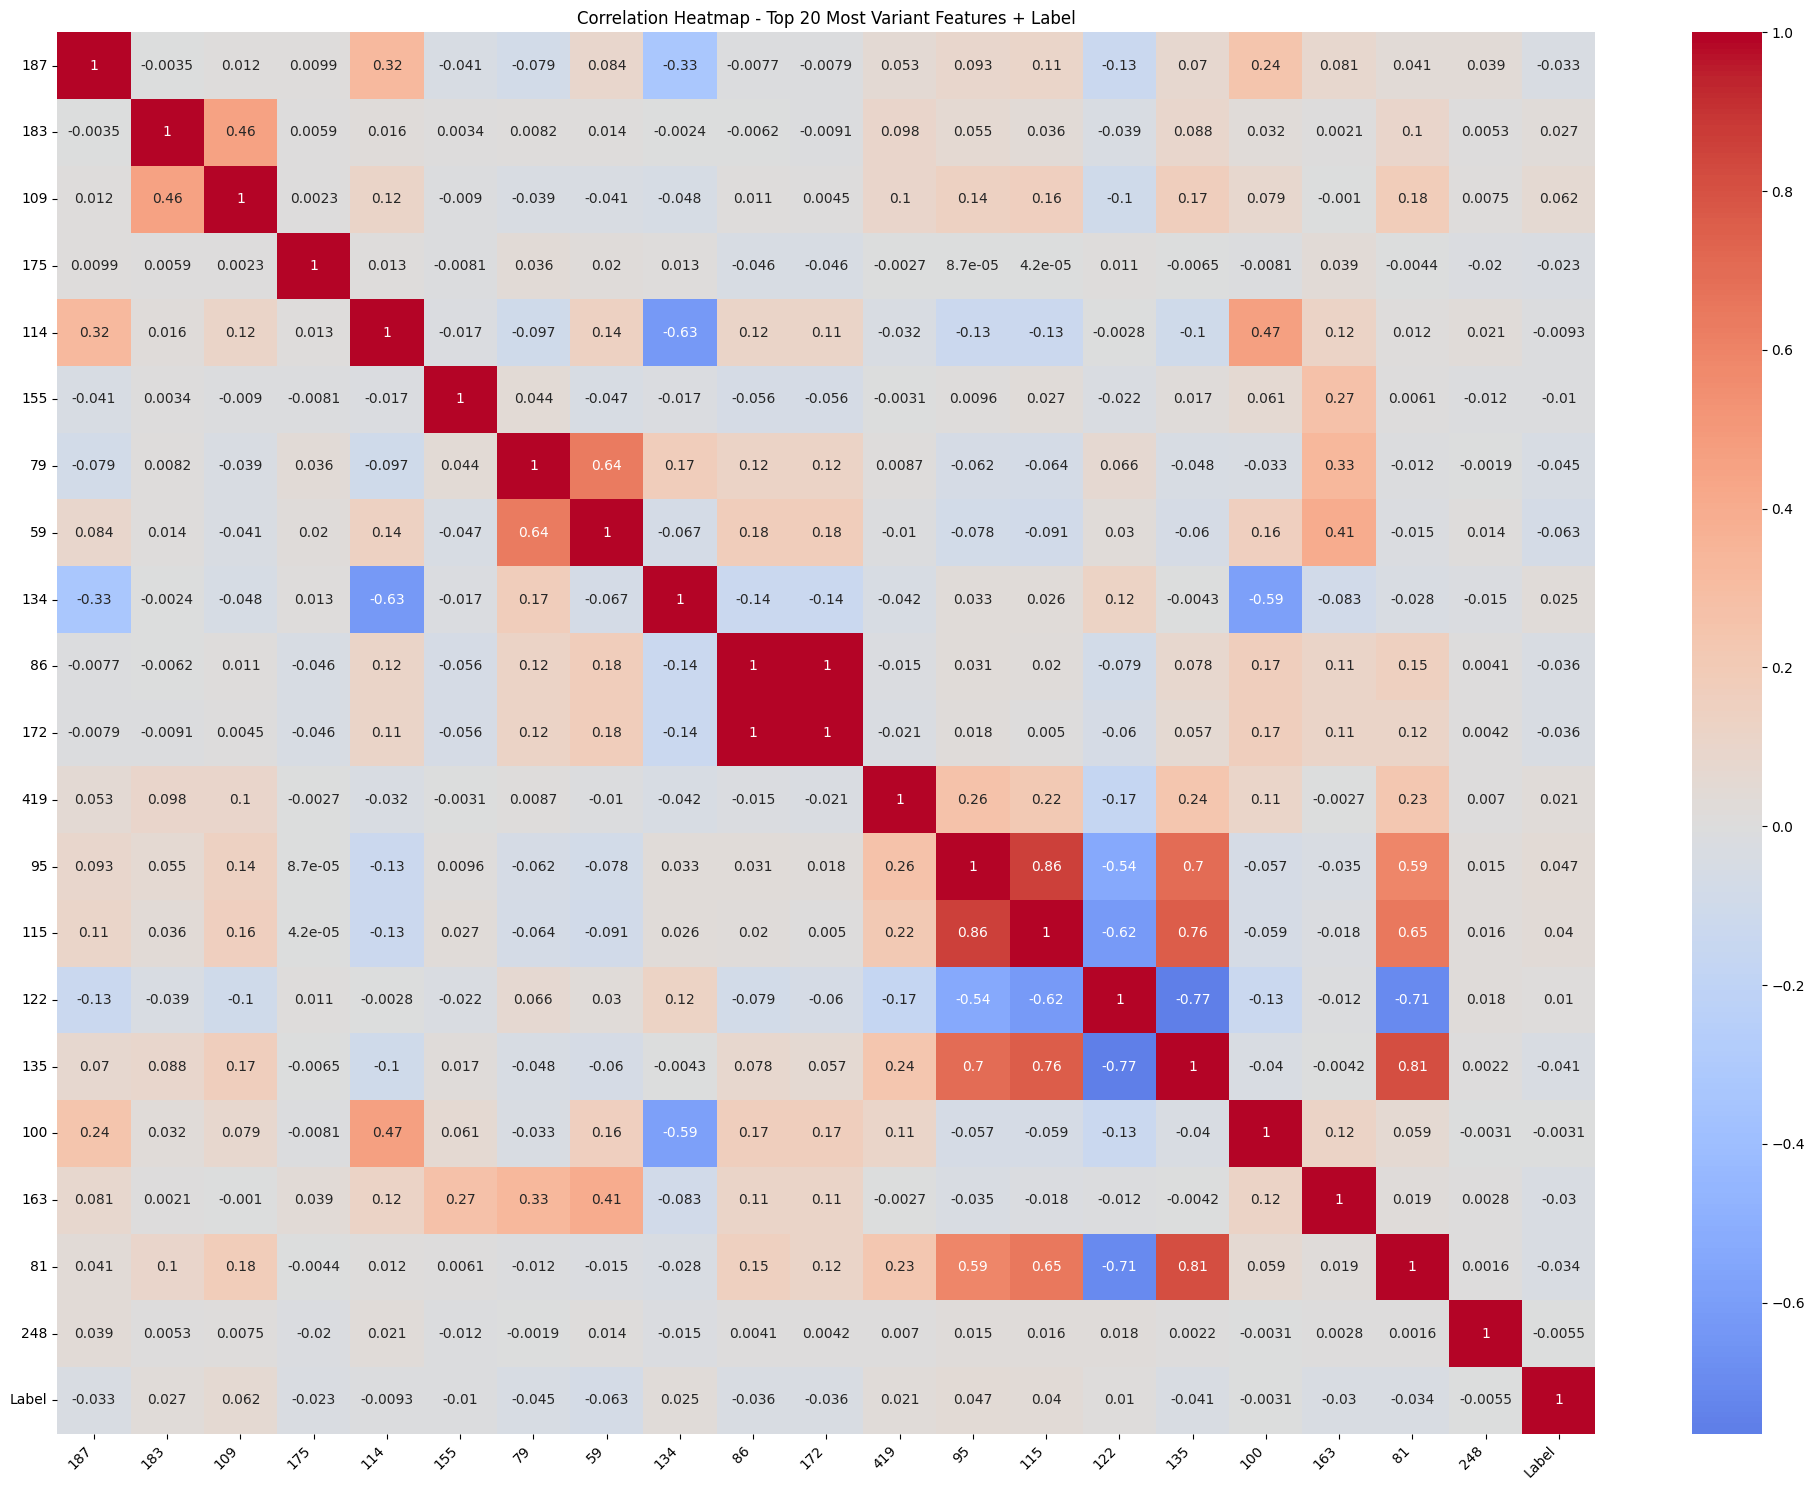

In [68]:
variances = X_train_df.var().sort_values(ascending=False)

top_features = variances.head(20).index.tolist()

X_corr_with_target = X_train_df[top_features].copy()
X_corr_with_target['Label'] = y_train 

plt.figure(figsize=(20, 15))
sns.heatmap(X_corr_with_target.corr(), cmap='coolwarm', center=0, annot=True)
plt.title("Correlation Heatmap - Top 20 Most Variant Features + Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

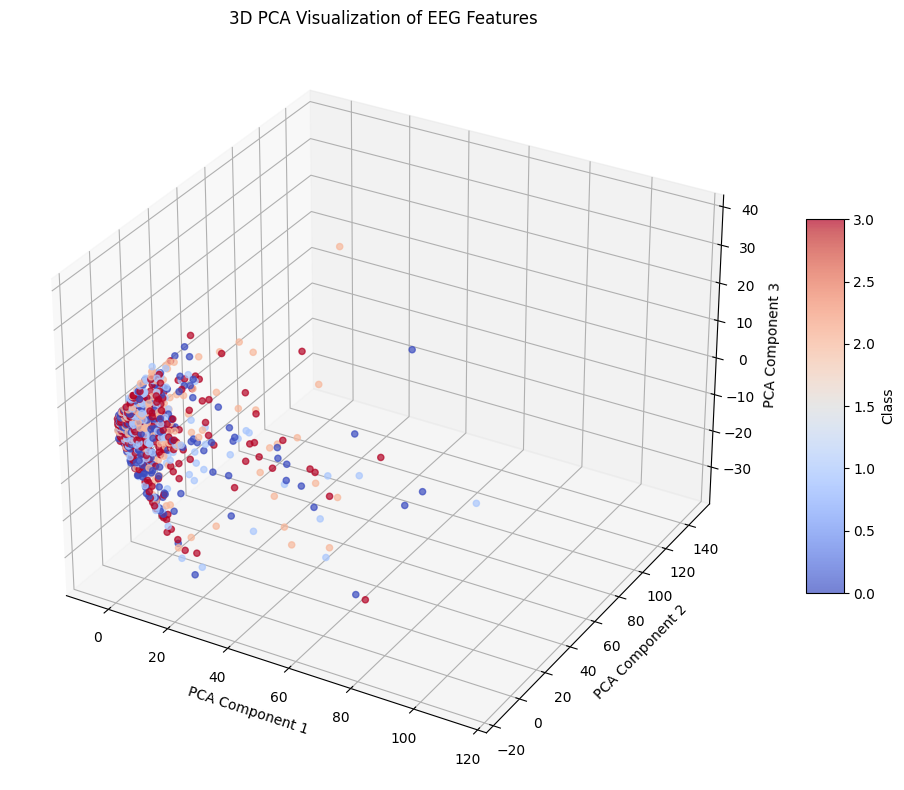

In [69]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap='coolwarm', alpha=0.7)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Visualization of EEG Features')

legend = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
legend.set_label('Class')

plt.tight_layout()
plt.show()

## SSVEP Data Augmentation

In [70]:
def ssvep_augment(X, y, shift_range=(-0.5, 0.5), n_augmented_per_class=None, seed=42):
    np.random.seed(seed)
    unique_classes = np.unique(y)
    X_aug_list = []
    y_aug_list = []

    frequency_features = [i for i in range(X.shape[1]) if 'fft' in str(i) or 'power' in str(i) or 'peak' in str(i)]

    for cls in unique_classes:
        class_indices = np.where(y == cls)[0]
        n_samples = n_augmented_per_class or (len(class_indices) // 2)
        sampled_indices = np.random.choice(class_indices, size=n_samples, replace=True)

        for idx in sampled_indices:
            sample = X[idx].copy()
            shift = 1 + (np.random.uniform(*shift_range) / 10.0)
            sample[frequency_features] *= shift
            X_aug_list.append(sample)
            y_aug_list.append(cls)

    X_aug = np.vstack([X, np.array(X_aug_list)])
    y_aug = np.hstack([y, np.array(y_aug_list)])
    return X_aug, y_aug

In [71]:
X_train, y_train = ssvep_augment(X_train, y_train, seed=51)

## Building & Training SSVEP Model

In [72]:
base_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)

importances = base_model.feature_importances_
top_k = 100
indices = np.argsort(importances)[::-1][:top_k]

if isinstance(X_train, np.ndarray):
    X_train_selected = X_train[:, indices]
else:
    X_train_selected = X_train.to_numpy()[:, indices]

if isinstance(X_val, np.ndarray):
    X_val_selected = X_val[:, indices]
else:
    X_val_selected = X_val.to_numpy()[:, indices]

if isinstance(X_test, np.ndarray):
    X_test = X_test[:, indices]
else:
    X_test = X_test.to_numpy()[:, indices]
    
print("✅ Selected features shape:", X_train_selected.shape)

✅ Selected features shape: (3599, 100)


In [73]:
np.save("SSVEP_indices.npy", indices)

In [74]:
xgb_model_SSVEP = XGBClassifier(
    n_estimators=900,
    max_depth=1,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=4
)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model_SSVEP, X_train_selected, y_train, cv=kf, scoring='accuracy')
print("Mean CV Accuracy:", scores.mean())

xgb_model_SSVEP.fit(X_train_selected, y_train, sample_weight=sample_weights)

y_train_pred = xgb_model_SSVEP.predict(X_train_selected)
y_val_pred = xgb_model_SSVEP.predict(X_val_selected)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred, digits=4))

Mean CV Accuracy: 0.6010136180748994
Train Accuracy: 0.6682411781050291
Validation Accuracy: 0.62

Confusion Matrix:
 [[9 1 3 1]
 [0 7 1 2]
 [0 2 8 2]
 [1 4 2 7]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9000    0.6429    0.7500        14
           1     0.5000    0.7000    0.5833        10
           2     0.5714    0.6667    0.6154        12
           3     0.5833    0.5000    0.5385        14

    accuracy                         0.6200        50
   macro avg     0.6387    0.6274    0.6218        50
weighted avg     0.6525    0.6200    0.6251        50



In [75]:
joblib.dump(xgb_model_SSVEP, 'SSVEP_Model.pkl')

['SSVEP_Model.pkl']

## Saving SSVEP Predictions

In [76]:
y_preds = xgb_model_SSVEP.predict(X_test)

In [77]:
df_predictions_SSVEP = pd.DataFrame({
    'id':  range(4951, 4951 + len(y_preds)),
    'label': y_preds
})

In [78]:
df_predictions_SSVEP

,id,label
0,4951,3
1,4952,3
2,4953,2
3,4954,3
4,4955,3
5,4956,0
6,4957,3
7,4958,2
8,4959,1
9,4960,1


In [79]:
df_predictions_SSVEP['label'].value_counts()

label
3    18
2    12
1    11
0     9
Name: count, dtype: int64

# Merging Predictions

In [80]:
df_predictions = pd.concat([df_predictions_MI, df_predictions_SSVEP], ignore_index=True)

In [81]:
df_predictions

,id,label
0,4901,0
1,4902,1
2,4903,1
3,4904,1
4,4905,1
...,...,...
95,4996,1
96,4997,2
97,4998,1
98,4999,3


In [82]:
inv_label_map = {v: k for k, v in label_map.items()}
df_predictions['label'] = df_predictions['label'].map(inv_label_map)
df_predictions['label'] = df_predictions['label'].str.title()
df_predictions

,id,label
0,4901,Left
1,4902,Right
2,4903,Right
3,4904,Right
4,4905,Right
...,...,...
95,4996,Right
96,4997,Forward
97,4998,Right
98,4999,Backward


In [83]:
df_predictions['label'].value_counts()

label
Left        35
Right       35
Backward    18
Forward     12
Name: count, dtype: int64

In [84]:
df_predictions.to_csv('predictions.csv', index=False)